### Importing necesary dependencies

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Dropout

from glob import glob
import os
import gc
import random
import cv2
import yaml
import numpy as np
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


## Getting Data

### Image paths and labels

In [2]:
img_paths = []
labels = []

### Getting Data from simulator

In [3]:
SIM_DATA_DIR = os.path.join('data', 'sim')

sim_file_paths_green = glob(os.path.join(SIM_DATA_DIR, 'green*', '*.png'))
sim_file_paths_yellow = glob(os.path.join(SIM_DATA_DIR, 'yellow*', '*.png'))
sim_file_paths_red = glob(os.path.join(SIM_DATA_DIR, 'red*', '*.png'))
sim_file_paths_none = glob(os.path.join(SIM_DATA_DIR, 'none*', '*.png'))
print('From Simulator - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(sim_file_paths_green), len(sim_file_paths_yellow), len(sim_file_paths_red), len(sim_file_paths_none)))


img_paths.extend(sim_file_paths_green)
labels.extend([[1.0, 0.0, 0.0, 0.0] for i in range(len(sim_file_paths_green))])

img_paths.extend(sim_file_paths_yellow)
labels.extend([[0.0, 1.0, 0.0, 0.0] for i in range(len(sim_file_paths_yellow))])

img_paths.extend(sim_file_paths_red)
labels.extend([[0.0, 0.0, 1.0, 0.0] for i in range(len(sim_file_paths_red))])

img_paths.extend(sim_file_paths_none)
labels.extend([[0.0, 0.0, 0.0, 1.0] for i in range(len(sim_file_paths_none))])

From Simulator - Green: 928, Yellow: 320, Red: 1176, None: 2219


### Getting Data from rosbag

In [4]:
ROSBAG_DATA_DIR = os.path.join('data', 'rosbag')

rosbag_file_paths_green = glob(os.path.join(ROSBAG_DATA_DIR, 'green*', '*.jpg'))
rosbag_file_paths_yellow = glob(os.path.join(ROSBAG_DATA_DIR, 'yellow*', '*.jpg'))
rosbag_file_paths_red = glob(os.path.join(ROSBAG_DATA_DIR, 'red*', '*.jpg'))
rosbag_file_paths_none = glob(os.path.join(ROSBAG_DATA_DIR, 'none*', '*.jpg'))
print('From Rosbag - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    len(rosbag_file_paths_green), len(rosbag_file_paths_yellow), len(rosbag_file_paths_red),
    len(rosbag_file_paths_none)))


img_paths.extend(rosbag_file_paths_green)
labels.extend([[1.0, 0.0, 0.0, 0.0] for i in range(len(rosbag_file_paths_green))])

img_paths.extend(rosbag_file_paths_yellow)
labels.extend([[0.0, 1.0, 0.0, 0.0] for i in range(len(rosbag_file_paths_yellow))])

img_paths.extend(rosbag_file_paths_red)
labels.extend([[0.0, 0.0, 1.0, 0.0] for i in range(len(rosbag_file_paths_red))])

img_paths.extend(rosbag_file_paths_none)
labels.extend([[0.0, 0.0, 0.0, 1.0] for i in range(len(rosbag_file_paths_none))])

From Rosbag - Green: 318, Yellow: 217, Red: 379, None: 273


### Getting Data from Heidelberg set

In [5]:
HEIDELBERG_DATA_DIR = os.path.join('data', 'heidelberg')
HEIDELBERG_TRAIN_YAML_FILE = os.path.join(HEIDELBERG_DATA_DIR, 'train.yaml')

dataset_info = []

for yaml_path in [HEIDELBERG_TRAIN_YAML_FILE]:

    yaml_file = open(yaml_path, 'r')
    loaded_yaml = yaml_file.read()
    yaml_file.close()
    dataset_info.extend(yaml.load(loaded_yaml))

print('Heidelberg data set loaded')

Heidelberg data set loaded


In [6]:
count_green = 0
count_yellow = 0
count_red = 0
count_none = 0

for i in range(len(dataset_info)):
    img_desc = dataset_info[i]
    img_path = os.path.join(HEIDELBERG_DATA_DIR, img_desc['path'])

    boxes = img_desc['boxes']

    if boxes is None or len(boxes) < 1:
        img_paths.append(img_path)
        labels.append([0.0, 0.0, 0.0, 1.0])
        count_none += 1
    else:
        t = np.array([0, 0, 0])

        for box in boxes:
            label = box['label']
            if label == 'Green':
                t += [1, 0, 0]
            elif label == 'Yellow':
                t += [0, 1, 0]
            elif label == 'Red':
                t += [0, 0, 1]

        t = t > 0
        if np.sum(t) <= 1:
            if t[0]:
                img_paths.append(img_path)
                labels.append([1.0, 0.0, 0.0, 0.0])
                count_green += 1
            elif t[1]:
                img_paths.append(img_path)
                labels.append([0.0, 1.0, 0.0, 0.0])
                count_yellow += 1
            elif t[2]:
                img_paths.append(img_path)
                labels.append([0.0, 0.0, 1.0, 0.0])
                count_red += 1
            else:
                img_paths.append(img_path)
                labels.append([0.0, 0.0, 0.0, 1.0])
                count_none += 1

print('From Heidelberg set - Green: {}, Yellow: {}, Red: {}, None: {}'.format(
    count_green, count_yellow, count_red, count_none))

From Heidelberg set - Green: 1366, Yellow: 87, Red: 809, None: 2032


### Combined training and test (validation) sets

In [7]:
img_paths, labels = shuffle(img_paths, labels)

print('Total - imgs: {}, labels: {}'.format(len(img_paths), len(labels)))


img_paths_train, img_paths_test, labels_train, labels_test = train_test_split(img_paths, labels, test_size=0.2)

print('Train - imgs: {}, labels: {}'.format(len(img_paths_train), len(labels_train)))
print('Test - imgs: {}, labels: {}'.format(len(img_paths_test), len(labels_test)))

Total - imgs: 10124, labels: 10124
Train - imgs: 8099, labels: 8099
Test - imgs: 2025, labels: 2025


### Testing training/validation sets

Image Path: data/sim/red/sim_397.png
Image Shape: (224, 224, 3)
Image Label: [0.0, 0.0, 1.0, 0.0]
Image Class: red


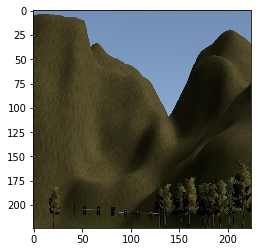

In [17]:
i = (int)(random.random() * len(img_paths))
img_path = img_paths[i]
print('Image Path: {}'.format(img_path))

img = cv2.resize(cv2.imread(img_path), (224, 224))
label = labels[i]

print('Image Shape: {}'.format(img.shape))
print('Image Label: {}'.format(label))
print('Image Class: {}'.format(
    'green' if label[0] else ('yellow' if label[1] else ('red' if label[2] else 'none'))))
plt.imshow(img[:,:,::-1])

## Traffic-Light Classifier

### Convolutional Neural Network

In [18]:
NO_CLASSES = 4

def classifier():
    inputs = Input(shape=(224, 224, 3), name="in_input")
    resnet = ResNet50(weights='imagenet', input_tensor=inputs)
    x = resnet.output

    x = Dropout(0.5, name="out_dropout_1")(x)
    x = Dense(100, activation='relu', name="out_dense_1")(x)
    x = Dropout(0.5, name="out_dropout_2")(x)
    x = Dense(NO_CLASSES, activation='softmax', name="out_dense_2")(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# Uncoment to remove model and collect garbage
#del classifier_model
#gc.collect()

In [19]:
classifier_model = classifier()
classifier_model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=['accuracy'])
print(classifier_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
in_input (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        in_input[0][0]                   
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### Data sample generator

In [20]:
def generate_sample(batch_size, img_paths_sample, labels_sample):
    while True:
        for batch_i in range(0, len(img_paths_sample), batch_size):
            imgs = []
            lbs = labels_sample[batch_i:batch_i+batch_size]
            for img_path in img_paths_sample[batch_i:batch_i+batch_size]:
                imgs.append(cv2.resize(cv2.imread(img_path), (224, 224)))
            yield np.array(imgs), np.array(lbs)

### Traning model

In [21]:
BATCH_SIZE = 5
STEEPS_PER_EPOCH = len(img_paths_train) / BATCH_SIZE
TEST_STEEPS_PER_EPOCH = len(img_paths_test) / BATCH_SIZE

def train_classifier(epochs):

    classifier_model.fit_generator(
        generate_sample(BATCH_SIZE, img_paths_train, labels_train),
        steps_per_epoch=STEEPS_PER_EPOCH, 
        epochs=epochs,
        validation_data = generate_sample(BATCH_SIZE, img_paths_test, labels_test),
        validation_steps = TEST_STEEPS_PER_EPOCH)

In [22]:
train_classifier(10)

Epoch 1/10
1619/1619 [==============================] - 765s - loss: 0.5196 - acc: 0.7503 - val_loss: 0.5039 - val_acc: 0.7500
Epoch 2/10
1619/1619 [==============================] - 761s - loss: 0.4946 - acc: 0.7517 - val_loss: 0.4810 - val_acc: 0.7500
Epoch 3/10
1619/1619 [==============================] - 758s - loss: 0.4778 - acc: 0.7670 - val_loss: 0.4614 - val_acc: 0.7706
Epoch 4/10
1619/1619 [==============================] - 758s - loss: 0.4652 - acc: 0.7754 - val_loss: 0.4429 - val_acc: 0.8367
Epoch 5/10
1619/1619 [==============================] - 758s - loss: 0.4430 - acc: 0.7899 - val_loss: 0.3875 - val_acc: 0.8495
Epoch 6/10
1619/1619 [==============================] - 758s - loss: 0.4132 - acc: 0.8028 - val_loss: 0.3574 - val_acc: 0.8517
Epoch 7/10
1619/1619 [==============================] - 758s - loss: 0.4012 - acc: 0.8103 - val_loss: 0.3424 - val_acc: 0.8477
Epoch 8/10
1619/1619 [==============================] - 758s - loss: 0.3810 - acc: 0.8218 - val_loss: 0.3023 - 

In [26]:
train_classifier(10)

Epoch 1/10
1619/1619 [==============================] - 758s - loss: 0.3399 - acc: 0.8462 - val_loss: 0.2471 - val_acc: 0.9227
Epoch 2/10
1619/1619 [==============================] - 757s - loss: 0.3251 - acc: 0.8587 - val_loss: 0.2537 - val_acc: 0.9089
Epoch 3/10
1619/1619 [==============================] - 757s - loss: 0.3057 - acc: 0.8701 - val_loss: 0.2609 - val_acc: 0.9022
Epoch 4/10
1619/1619 [==============================] - 757s - loss: 0.2903 - acc: 0.8767 - val_loss: 0.2119 - val_acc: 0.9275
Epoch 5/10
1619/1619 [==============================] - 758s - loss: 0.2770 - acc: 0.8812 - val_loss: 0.2164 - val_acc: 0.9143
Epoch 6/10
1619/1619 [==============================] - 757s - loss: 0.2828 - acc: 0.8786 - val_loss: 0.2213 - val_acc: 0.9209
Epoch 7/10
1619/1619 [==============================] - 757s - loss: 0.2713 - acc: 0.8829 - val_loss: 0.2403 - val_acc: 0.9217
Epoch 8/10
1619/1619 [==============================] - 757s - loss: 0.2619 - acc: 0.8862 - val_loss: 0.2200 - 

In [29]:
train_classifier(10)

Epoch 1/10
1619/1619 [==============================] - 757s - loss: 0.2433 - acc: 0.8932 - val_loss: 0.2201 - val_acc: 0.9337
Epoch 2/10
1619/1619 [==============================] - 757s - loss: 0.2608 - acc: 0.8861 - val_loss: 0.2042 - val_acc: 0.9391
Epoch 3/10
1619/1619 [==============================] - 757s - loss: 0.2451 - acc: 0.8912 - val_loss: 0.2865 - val_acc: 0.9154
Epoch 4/10
1619/1619 [==============================] - 757s - loss: 0.2401 - acc: 0.8935 - val_loss: 0.2207 - val_acc: 0.9398
Epoch 5/10
1619/1619 [==============================] - 757s - loss: 0.2459 - acc: 0.8920 - val_loss: 0.2050 - val_acc: 0.9431
Epoch 6/10
1619/1619 [==============================] - 757s - loss: 0.2393 - acc: 0.8932 - val_loss: 0.1826 - val_acc: 0.9453
Epoch 7/10
1619/1619 [==============================] - 757s - loss: 0.2315 - acc: 0.8967 - val_loss: 0.1880 - val_acc: 0.9474
Epoch 8/10
1619/1619 [==============================] - 757s - loss: 0.2235 - acc: 0.8996 - val_loss: 0.1869 - 

In [61]:
train_classifier(10)

Epoch 1/10
1619/1619 [==============================] - 757s - loss: 0.2246 - acc: 0.8985 - val_loss: 0.2074 - val_acc: 0.9452
Epoch 2/10
1619/1619 [==============================] - 757s - loss: 0.2239 - acc: 0.8979 - val_loss: 0.1867 - val_acc: 0.9504
Epoch 3/10
1619/1619 [==============================] - 757s - loss: 0.2198 - acc: 0.8989 - val_loss: 0.1697 - val_acc: 0.9516
Epoch 4/10
1619/1619 [==============================] - 758s - loss: 0.2204 - acc: 0.9003 - val_loss: 0.1688 - val_acc: 0.9493
Epoch 5/10
1619/1619 [==============================] - 757s - loss: 0.2070 - acc: 0.9069 - val_loss: 0.1680 - val_acc: 0.9477
Epoch 6/10
1619/1619 [==============================] - 757s - loss: 0.1955 - acc: 0.9142 - val_loss: 0.1927 - val_acc: 0.9468
Epoch 7/10
1619/1619 [==============================] - 757s - loss: 0.1969 - acc: 0.9121 - val_loss: 0.1757 - val_acc: 0.9514
Epoch 8/10
1619/1619 [==============================] - 759s - loss: 0.2005 - acc: 0.9121 - val_loss: 0.2406 - 

In [81]:
train_classifier(1)

Epoch 1/1
1619/1619 [==============================] - 756s - loss: 0.1886 - acc: 0.9144 - val_loss: 0.1861 - val_acc: 0.9543


### Testing the trained model

Image Path: data/heidelberg/./rgb/train/2015-10-05-14-40-46_bag/477202.png
Image Shape: (224, 224, 3)
Image Label: [1.0, 0.0, 0.0, 0.0]
Image Class: green
Prediction: [0.9545212  0.01345195 0.02299643 0.00903038]
Predicted Class: green


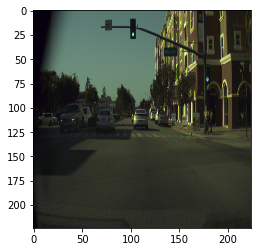

In [84]:
i = (int)(random.random() * len(img_paths))
img_path = img_paths[i]
print('Image Path: {}'.format(img_path))

img = cv2.resize(cv2.imread(img_path), (224, 224))
label = labels[i]

print('Image Shape: {}'.format(img.shape))
print('Image Label: {}'.format(label))
print('Image Class: {}'.format(
    'green' if label[0] else ('yellow' if label[1] else ('red' if label[2] else 'none'))))
plt.imshow(img[:,:,::-1])


pred = classifier_model.predict(img.reshape(1,224,224,3))[0]
print('Prediction: {}'.format(pred))
img_cls = np.argmax(pred)
print('Predicted Class: {}'.format(
    'green' if img_cls==0 else ('yellow' if img_cls==1 else ('red' if img_cls==2 else 'none'))))

### Saving the trained model

In [82]:
CLASSIFIER_MODEL_WEIGHTS_FILE = os.path.join('models', 'classifier_model_weights.h5')
CLASSIFIER_MODEL_YAML_FILE = os.path.join('models', 'classifier_model.yaml')

In [83]:
# Saving the weights
classifier_model.save_weights(CLASSIFIER_MODEL_WEIGHTS_FILE)

# Saving the architecture
classifier_model_yaml = classifier_model.to_yaml()
with open(CLASSIFIER_MODEL_YAML_FILE, "w") as classifier_yaml_file:
    classifier_yaml_file.write(classifier_model_yaml)